<h1 style="text-align: center;">Generative Adversarial Networks (GANs)</h1>


## Overview

Generative Adversarial Networks (GANs) are a class of machine learning frameworks designed to generate new, synthetic data samples that resemble a given training dataset. GANs consist of two neural networks, the **Generator** and the **Discriminator**, which are trained simultaneously through an adversarial process:

- **Generator**: This network creates synthetic data (e.g., images) from random noise. Its goal is to produce data that is indistinguishable from real data.
- **Discriminator**: This network evaluates whether a given data sample is real (from the training set) or fake (generated by the Generator). Its goal is to correctly classify data as real or fake.

During training, the Generator tries to improve its ability to generate realistic data, while the Discriminator strives to become better at distinguishing between real and fake data. This adversarial process drives both networks to improve over time, resulting in the Generator producing high-quality synthetic data.

## Objectives of This Notebook

The main objective of this notebook is to build and train a Generative Adversarial Network (GAN) with the specific goal of generating CIFAR-10 images. We will start by defining and constructing the architecture for both the Generator and Discriminator networks using Keras. Once the models are built, we will prepare and preprocess the CIFAR-10 dataset for training. The training process involves iterating through multiple epochs to refine the Generator's ability to produce realistic CIFAR-10 images and enhance the Discriminator's capability to distinguish between real and fake images. After training, we will use the Generator to create new CIFAR-10 images from random noise vectors, post-process these images to ensure they are in a displayable format, and visualize the results in a grid format. By the end of this notebook, we aim to have a functional GAN that generates CIFAR-10 images and can evaluate its performance through visualization.




## Importing Required Libraries


In [1]:
import numpy as np
from numpy import zeros, ones
from numpy.random import randn,randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from matplotlib import pyplot as plt
import pandas as pd

from keras.models import load_model

Using TensorFlow backend.


## Loading the CIFAR-10 Dataset

This function is responsible for loading the CIFAR-10 dataset from a local `.npz` file. The CIFAR-10 dataset is commonly used for machine learning tasks, particularly in computer vision, and consists of 60,000 32x32 color images across 10 different classes.

- **Data Loading**: The data is loaded from a compressed `.npz` file containing training and test sets.
- **Data Structure**:
  - `X_train`: Training images
  - `y_train`: Training labels
  - `X_test`: Test images
  - `y_test`: Test labels

The function returns a tuple containing the training data and the test data.

In [2]:
def load_data():
    data = np.load('/kaggle/input/cifar10-keras-files-cifar10load-data/cifar-10.npz')
    
    X_train = data['x_train']
    y_train = data['y_train']
    X_test = data['x_test']
    y_test = data['y_test']
    
    return (X_train, y_train), (X_test, y_test)

## Visualizing the CIFAR-10 Training Data

In this section, we visualize a subset of the training data to get a better understanding of the images contained in the CIFAR-10 dataset.

- **Data Loading**: We call the `load_data()` function to retrieve the training and test datasets.
- **Image Display**:
  - We loop through the first 25 images in the training dataset (`X_train`).
  - Each image is plotted in a 5x5 grid using `Matplotlib`'s `plt.subplot()` function.
  - We use `plt.axis('off')` to hide the axis for a cleaner image display.
  - Finally, we call `plt.imshow()` to display each image, and `plt.show()` to render the entire grid.


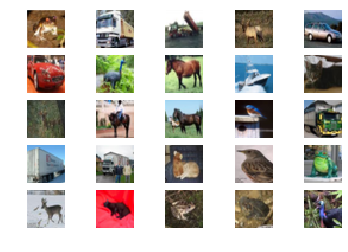

In [3]:
(X_train, y_train), (X_test, y_test) = load_data()

for i in range(25):
    plt.subplot(5,5,1+i)
    plt.axis('off')
    plt.imshow(X_train[i])
    
plt.show()

## Building the Discriminator Model

The **Discriminator** is a key component of Generative Adversarial Networks (GANs). Its purpose is to classify images as real or fake. In this section, we define the Discriminator using a Convolutional Neural Network (CNN) architecture.

### Model Architecture:
- **Input Shape**: The input shape is set to `(32, 32, 3)` corresponding to the size of CIFAR-10 images (32x32 pixels, 3 color channels).
- **Layers**:
  1. **Conv2D Layer**: A convolutional layer with 128 filters, using a 3x3 kernel, and stride of 2x2 for downsampling. Padding is set to 'same' to maintain the input size.
  2. **LeakyReLU Activation**: A non-linearity with an alpha value of 0.2 to allow for small negative gradients, improving learning.
  3. **Conv2D Layer**: Another convolutional layer with the same configuration for further feature extraction.
  4. **LeakyReLU Activation**: Same as the first layer.
  5. **Flatten Layer**: Converts the 2D feature maps into a 1D vector.
  6. **Dropout Layer**: Adds a dropout of 40% to prevent overfitting.
  7. **Dense Layer**: The final output layer with a single neuron and a sigmoid activation function to output a probability (real or fake).

### Compilation:
- The model is compiled using **binary cross-entropy** as the loss function (suitable for binary classification).
- The **Adam optimizer** is used with a learning rate of 0.0002 and `beta_1` set to 0.5, which helps in stabilizing the training of GANs.


In [4]:
def Discriminator(inputShape=(32,32,3)):
    model=Sequential()
    
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same',input_shape=inputShape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation="sigmoid"))
    
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0002,beta_1=0.5),metrics=['accuracy'])
    return model

## Building the Generator Model

The **Generator** is another crucial component of Generative Adversarial Networks (GANs). Its role is to generate fake images that are intended to be indistinguishable from real images, aiming to fool the Discriminator.

### Model Architecture:
- **Input Dimension**: The input to the generator is a latent vector (`dim`), typically a random noise vector, which will be transformed into a 32x32 image.
- **Layers**:
  1. **Dense Layer**: The first fully connected layer, with `128 * 8 * 8` nodes (this corresponds to an 8x8 feature map with 128 channels). It takes the latent dimension as input and produces this large vector.
  2. **LeakyReLU Activation**: Adds non-linearity with an alpha of 0.2, allowing some small negative values for better learning.
  3. **Reshape Layer**: The output of the dense layer is reshaped into a 3D tensor of shape (8, 8, 128), representing the feature maps.
  4. **Conv2DTranspose Layer**: This layer upsamples the feature map using 128 filters with a 4x4 kernel and a stride of 2x2, effectively doubling the spatial dimensions to 16x16. Padding is set to 'same' to maintain spatial dimensions.
  5. **LeakyReLU Activation**: Adds non-linearity again after upsampling.
  6. **Conv2DTranspose Layer**: Another transposed convolution layer, identical to the previous one, upsampling the 16x16 feature maps to the desired 32x32 size.
  7. **LeakyReLU Activation**: Non-linearity applied again.
  8. **Conv2D Layer**: The final convolutional layer reduces the feature maps to 3 channels (RGB) with a large 8x8 kernel. A **tanh activation** is used to scale the output values between -1 and 1, which is typical for image generation tasks, as the pixel values are normalized in this range.

### Output:
- The output is a 32x32x3 image (CIFAR-10 size).


In [5]:
def Generator(dim):
    model=Sequential()
    nodes=128*8*8
    model.add(Dense(nodes,input_dim=dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8,8,128)))
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3,(8,8),activation='tanh',padding='same'))
    
    return model

## Building the GAN (Generative Adversarial Network)

The **GAN** is created by combining the **Generator** and **Discriminator** models. The Generator attempts to create fake images that resemble real ones, while the Discriminator tries to differentiate between real and fake images. The goal of the GAN is to train the Generator to create images that can fool the Discriminator.

### Process:
1. **Disabling Discriminator Training**: 
   - We set `disc.trainable = False` to freeze the weights of the Discriminator during the GAN training. This ensures that only the Generator is updated during training, as the Discriminator is supposed to remain a strong classifier.
   
2. **Combining the Models**:
   - The **Sequential** model adds the Generator (`gen`) followed by the Discriminator (`disc`), effectively connecting the two models end-to-end.
   - The Generator outputs an image, and the Discriminator immediately evaluates it, producing the final GAN output.

3. **Compilation**:
   - The GAN is compiled with a **binary cross-entropy** loss function, which is suitable for binary classification (real vs fake).
   - The **Adam optimizer** is used with a learning rate of 0.0002 and `beta_1` set to 0.5, which is a commonly used configuration for stabilizing GAN training.

### Objective:
- The goal of the GAN is to update the Generator's weights to produce increasingly realistic images while keeping the Discriminator’s weights unchanged during this phase.


In [6]:
def GAN(gen,disc):
    disc.trainable = False
    
    model=Sequential()
    model.add(gen)
    model.add(disc)
    
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0002,beta_1=0.5))
    
    return model

## Preparing Real Samples for GAN Training

In this section, we define a helper function called `real_simples` that loads and preprocesses real images from the CIFAR-10 dataset. These real samples will be used to train the Discriminator as part of the GAN training process.

### Steps:
1. **Loading the Data**:
   - We use the `load_data()` function to load the CIFAR-10 dataset. The training images `X_train` are extracted.

2. **Data Type Conversion**:
   - The training images are converted to `float32` to ensure compatibility with the neural network, as the default data type in the CIFAR-10 dataset may be `uint8`.

3. **Normalizing the Data**:
   - The pixel values of the images are scaled to a range of [-1, 1] by subtracting 127.5 and dividing by 127.5. This normalization is essential for GAN training because the Generator uses a `tanh` activation in the output layer, which expects inputs in this range.

### Output:
- The function returns the preprocessed training images `X_train`, which are ready to be used for GAN training.


In [7]:
def real_simples():
    (X_train,_),(_,_)=load_data()
    
    X_train= X_train.astype('float32')
    X_train= (X_train - 127.5)/127.5
    
    return X_train

## Generating Real Samples for GAN Training

This function, `generate_real_simples`, is used to generate a batch of real images and corresponding labels from the preprocessed dataset. These real samples are used to train the Discriminator during each iteration of the GAN training process.

### Steps:
1. **Random Selection of Images**:
   - A random set of indices is generated using `randint()`, which selects a number of images from the dataset `data`. The size of the batch is determined by the `batch` parameter.

2. **Selecting Real Images**:
   - Using the generated random indices, a subset of real images (`X_train_real`) is selected from the dataset. This subset represents real examples that the Discriminator will learn to identify as real.

3. **Generating Real Labels**:
   - A corresponding set of labels (`y_train_real`) is created, consisting entirely of ones. Since these are real images, the label `1` is used to indicate "real" for the Discriminator's binary classification task.

### Output:
- The function returns two outputs:
  1. `X_train_real`: A batch of real images from the dataset.
  2. `y_train_real`: A batch of labels (all set to 1), indicating that these are real images.


In [8]:
def generate_real_simples(data, batch):
    index= randint(0,data.shape[0],batch)
    
    X_train_real=data[index]
    
    y_train_real= ones((batch,1))
    
    return X_train_real, y_train_real

## Generating Starting Points for the Generator

The `generate_starting_points` function creates a batch of random noise vectors that serve as the input for the Generator model in a GAN. These noise vectors are used to generate fake images.

### Steps:
1. **Generate Random Noise**:
   - Random noise vectors are generated using `randn()`. The total number of elements is `dim * batch`, where `dim` is the dimension of each noise vector and `batch` is the number of vectors.

2. **Reshape the Noise Vectors**:
   - The noise vectors are reshaped into a 2D array where each row represents a noise vector of dimension `dim`. The resulting shape is `(batch, dim)`, where `batch` is the number of noise vectors and `dim` is their dimension.

### Output:
- The function returns a 2D array `Input` where each row is a noise vector used as input for the Generator.


In [9]:
def generate_starting_points(dim,batch):
    Input=randn(dim*batch)
    Input=Input.reshape(batch,dim)
    
    return Input

## Generating Fake Samples for GAN Training

The `generate_fake_simples` function creates a batch of fake images generated by the Generator model. These fake samples are used to train the Discriminator to distinguish between real and fake images.

### Steps:
1. **Generating Input for the Generator**:
   - The function `generate_starting_points(dim, batch)` is called to produce a batch of random noise vectors (`Input`).

2. **Generating Fake Images**:
   - The Generator model (`Generator`) is used to generate fake images by predicting based on the input noise vectors. The `predict()` method of the Generator model outputs the generated images (`X_train_fake`).

3. **Generating Fake Labels**:
   - A corresponding set of labels (`y_train_fake`) is created, consisting entirely of zeros. These labels indicate that the images are fake, which helps train the Discriminator to recognize fake images.

### Output:
- The function returns two outputs:
  1. `X_train_fake`: A batch of fake images generated by the Generator.
  2. `y_train_fake`: A batch of labels (all set to 0), indicating that these images are fake.


In [10]:
def generate_fake_simples(Generator,dim,batch):
    Input=generate_starting_points(dim,batch)
    
    X_train_fake= Generator.predict(Input)
    y_train_fake= zeros((batch,1))
    
    return X_train_fake,y_train_fake

## Training the GAN

The `train` function trains the GAN model, consisting of the Generator (`gen`), Discriminator (`disc`), and combined GAN model (`gan`). It iteratively trains both the Discriminator and Generator over a specified number of epochs.

### Parameters:
- **`gen`**: The Generator model.
- **`disc`**: The Discriminator model.
- **`gan`**: The combined GAN model that connects the Generator and Discriminator.
- **`data`**: The real image data used for training.
- **`dim`**: The dimension of the noise vector input to the Generator.
- **`epochs`**: The number of epochs to train the GAN (default is 100).
- **`batch`**: The batch size for training (default is 128).

### Training Procedure:
1. **Batch Configuration**:
   - Calculate `batch_per_epoch` as the total number of batches per epoch.
   - Calculate `half_batch` as half of the total batch size. This is used to generate both real and fake samples.

2. **Epoch Loop**:
   - For each epoch:
     - **Batch Loop**:
       - Generate a batch of real images and corresponding labels.
       - Generate a batch of fake images and corresponding labels using the Generator.
       - Train the Discriminator on real images and fake images separately, calculating the loss for each.
       - Generate a batch of random noise vectors and use them to generate fake images for the GAN.
       - Train the GAN model with these generated images, using labels indicating "real" to update the Generator.


In [11]:
def train(gen, disc, gan, data, dim, epochs=100, batch=128):
    batch_per_epoch= int(data.shape[0]/batch)
    half_batch = int(batch/2)
    
    for i in range(epochs):
        for j in range(batch_per_epoch):
            X_train_real , y_train_real = generate_real_simples(data,half_batch)
            X_train_fake , y_train_fake = generate_fake_simples(gen,dim,half_batch)
            
            disc_loss_real,_ = disc.train_on_batch(X_train_real,y_train_real)
            disc_loss_fake,_ = disc.train_on_batch(X_train_fake,y_train_fake)
            
            X_train_GAN = generate_starting_points(dim,batch)
            
            y_train_GAN = ones((batch,1))
            
            GAN_loss = gan.train_on_batch(X_train_GAN,y_train_GAN)
            
            if i%100 == 0 and j%100 == 0: 
                print('[epoch-> %d]:  batch %d/%d ----- disc_loss_real: %.4f ----- disc_loss_fake: %.4f ----- gan_loss: %.4f'%
                     (i+1,j+1,batch_per_epoch,disc_loss_real,disc_loss_fake,GAN_loss))
    gen.save('cifar_generator.h5')

## Setting Up and Training the GAN

In this section, we set up the GAN models and initiate the training process using the CIFAR-10 dataset.

### Parameters and Models:
- **`dim`**: The dimension of the latent vector input to the Generator. Here, it is set to 100.
- **`disc`**: The Discriminator model, created using the `Discriminator()` function.
- **`gen`**: The Generator model, created using the `Generator(dim)` function with the latent vector dimension.
- **`gan`**: The combined GAN model, created using the `GAN(gen, disc)` function. 


In [12]:
dim = 100
disc = Discriminator()
gen = Generator(dim)
gan = GAN(gen,disc)

data = real_simples()

train(gen, disc, gan, data, dim, 1000)

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[epoch-> 1]:  batch 1/390 ----- disc_loss_real: 0.6988 ----- disc_loss_fake: 0.6963 ----- gan_loss: 0.6905


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[epoch-> 1]:  batch 101/390 ----- disc_loss_real: 0.4458 ----- disc_loss_fake: 0.5435 ----- gan_loss: 1.0018
[epoch-> 1]:  batch 201/390 ----- disc_loss_real: 0.2829 ----- disc_loss_fake: 0.7098 ----- gan_loss: 0.9888
[epoch-> 1]:  batch 301/390 ----- disc_loss_real: 0.7710 ----- disc_loss_fake: 0.4216 ----- gan_loss: 1.4095
[epoch-> 101]:  batch 1/390 ----- disc_loss_real: 0.6878 ----- disc_loss_fake: 0.6991 ----- gan_loss: 0.7088
[epoch-> 101]:  batch 101/390 ----- disc_loss_real: 0.6900 ----- disc_loss_fake: 0.6963 ----- gan_loss: 0.6956
[epoch-> 101]:  batch 201/390 ----- disc_loss_real: 0.6954 ----- disc_loss_fake: 0.6948 ----- gan_loss: 0.6961
[epoch-> 101]:  batch 301/390 ----- disc_loss_real: 0.6965 ----- disc_loss_fake: 0.6937 ----- gan_loss: 0.6974
[epoch-> 201]:  batch 1/390 ----- disc_loss_real: 0.6906 ----- disc_loss_fake: 0.6937 ----- gan_loss: 0.6956
[epoch-> 201]:  batch 101/390 ----- disc_loss_real: 0.6923 ----- disc_loss_fake: 0.6926 ----- gan_loss: 0.6957
[epoch-> 20

## Visualizing Generated Images

The `show_plot` function displays a grid of images, typically used to visualize the output of the Generator model after training.

### Parameters:
- **`X_test`**: The array of images to be displayed. This can be either generated images from the GAN or real images from the dataset.
- **`n`**: The number of images to display along one dimension of the grid. The function will create an `n x n` grid of images.


In [13]:
def show_plot(X_test, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(X_test[i, :, :, :])
	plt.show()

## Generating and Visualizing Images with the Trained GAN

In this section, we load the pretrained Generator model, generate new images using random noise vectors, and visualize them.

### Steps:

1. **Load the Pretrained Generator Model**:

In [14]:
model = load_model('cifar_generator.h5') 

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


- This command loads the Generator model that was previously saved in the file ``cifar_generator.h5``.

2. **Generate Random Noise Vectors:**



In [15]:
starting_points = generate_starting_points(100, 25)  

- Generate random noise vectors with a dimension of 100 and a batch size of 25 using the ``generate_starting_points()`` function. These vectors will be used as input for the Generator.
3. **Generate Images Using the Generator:**

In [16]:
X_test = model.predict(starting_points)

- Use the loaded Generator model to predict (generate) images based on the random noise vectors.
4. **Post-Process Generated Images:**

In [17]:
X_test = (X_test + 1) / 2.0
X_test = (X_test*255).astype(np.uint8)

- Convert the pixel values of the generated images from the range [-1, 1] to [0, 1] using the formula ``(X_test + 1) / 2.0``.
- Scale the pixel values from [0, 1] to [0, 255] and convert them to ``uint8`` format for proper display.
5. **Visualize the Generated Images:**

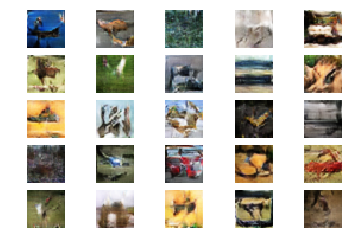

In [18]:
show_plot(X_test, 5)